In [191]:

using DataFrames
using RDatasets
using Statistics
using StatsPlots
using CSV
using StatsBase
using NamedArrays
using PrettyTables
using LIBSVM
using Printf
using SVR
using DecisionTree
using Shuffle
using Plots
using Distributions
using Zygote
using Flux

include(joinpath(dirname(pwd()), "plottraintest.jl"))

fsize = 5
ftsize = 5

5

In [192]:
df = CSV.read(joinpath(dirname(@__FILE__),"Concrete_Data.csv"), DataFrame)

Row,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Compressive strength (MPa)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
2,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
4,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.3
6,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.7
8,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
9,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85


In [193]:
dfm = Matrix(df)
dfms = dfm[shuffle(1:end), :]
#dfms = dfm

x = dfms[:, 1:8]
xnorm = (dfms[:, 1:8] .- mean(x,dims=1))./std(x,dims=1)
y = dfms[:, 9]

data_split = [0.6, 0.3, 0.1]
split_cs2 = Int.(round.(cumsum(data_split)*length(y)))
split_cs1 = vcat(1, split_cs2[1:(end-1)].+1)

xtrain = x[split_cs1[1]:split_cs2[1], :]'
xtrainnorm = xnorm[split_cs1[1]:split_cs2[1], :]'
ytrain = y[split_cs1[1]:split_cs2[1]]'

xtest = x[split_cs1[2]:split_cs2[2], :]'
xtestnorm = xnorm[split_cs1[2]:split_cs2[2], :]'
ytest = y[split_cs1[2]:split_cs2[2]]'

xval = x[split_cs1[3]:split_cs2[3], :]'
xvalnorm = xnorm[split_cs1[3]:split_cs2[3], :]'
yval = y[split_cs1[3]:split_cs2[3]]';



In [194]:
function dense_layer(x, p) 
	w, b = p 
	y = w*x .+ b
end

dense_layer (generic function with 1 method)

In [195]:
function train!(modelf, errf, p, x, labels, η, nsteps) 
	sample= rand(1:size(Matrix(x),2), 1000)
	for i= 1:nsteps 
		e(p) = errf(modelf(Matrix(x)[:,sample], p)[:], labels[sample])  
		p .-= η .* e'(p)
	end 
	return p
end

train! (generic function with 1 method)

In [196]:
function logit(x)
	1/(1+exp(-x))
end

logit (generic function with 1 method)

In [197]:
function relu(x) 
	return max(0,x)
end

relu (generic function with 1 method)

In [198]:
function logistic_regression(x::Matrix{T}, p::Vector) where T<:AbstractFloat
	logit.(dense_layer(x, p))
end

logistic_regression (generic function with 1 method)

In [199]:
function twolayer_logistic(x, p::Vector) where T<:AbstractFloat
	w1, b1, w2, b2 = p

	o1= relu.(dense_layer(x, [w1, b1]))
	o2 = dense_layer(o1, [w2, b2]) 
	o3 = logit.(o2)
	return o2
end

twolayer_logistic (generic function with 1 method)

In [200]:
function mse(ŷ, y)
	sum((ŷ .- y).^2) / length(y)
end

mse (generic function with 1 method)

In [201]:
function binary_crossentropy(ŷ::Vector{T}, y::Vector{T}) where T<:AbstractFloat
	-mean(y .* log.(ŷ) .+ (1.0 .- y) .* log.(1.0 .- ŷ))
end

binary_crossentropy (generic function with 1 method)

In [202]:
begin
	inputsize = 8
	hidensize=8
	nlabels = 1
	
	w1 = rand(hidensize, inputsize) .- 0.5
	b1 = rand(hidensize) .- 0.5
	
	w2 = rand(nlabels, hidensize) .- 0.5
	b2 = rand(nlabels) .- 0.5

	p = [w1,b1,w2,b2] 

	η = 0.000001
	nsteps = 100000
	
	pnorm = train!(twolayer_logistic, mse, p, xtrainnorm, ytrain, η, nsteps)

end

4-element Vector{Array{Float64}}:
 [0.07626732743772525 0.24545566928336393 … 0.17865113309508612 0.27863308511990087; 0.3648175815102532 0.9748098040272808 … -0.3577332109138977 0.44830404875663116; … ; 1.1596667860623917 0.21829377144491105 … 0.028802770282278803 0.6035870741167377; 0.11906513645847804 0.5325379249345651 … -0.4671513711403722 0.8314702837583986]
 [-0.48775627124056703, 2.5975124297684045, 0.6924655884735589, 0.7919362853060131, -0.2546543548819395, 2.883846751486085, 3.399217094145159, 1.3318673198294548]
 [0.1471366361577287 2.843384942726482 … 3.7449416481589344 1.7608657001694534]
 [2.413354931968737]

In [203]:
begin
	inputsize = 8
	hidensize=8
	nlabels = 1
	
	w1 = rand(hidensize, inputsize) .- 0.5
	b1 = rand(hidensize) .- 0.5
	
	w2 = rand(nlabels, hidensize) .- 0.5
	b2 = rand(nlabels) .- 0.5

	p = [w1,b1,w2,b2] 

	η = 0.000001
	nsteps = 100000
	
	p = train!(twolayer_logistic, mse, p, xtrain, ytrain, η, nsteps)

end

4-element Vector{Array{Float64}}:
 [0.1911574019706479 0.410618798169315 … -0.13258307932379843 0.21716439316525582; -0.2343272945056286 -0.08295336777206141 … 0.08927484264120056 0.17412732840790024; … ; -0.16138542284270427 -0.36138955453159494 … 0.15412925996152313 0.15238250760717317; 0.4682516949682984 0.06555401923260629 … 0.14667979335656214 -0.31368767475256504]
 [-0.40010884654677203, -0.02371620865956603, 0.36457399496374077, 0.3948112611823375, -0.24016852316514614, 0.316551700303905, 0.3730344657740988, 0.03277188430524511]
 [0.43721797411070795 -0.47742529641113507 … -0.39187481030637467 0.44858508955978216]
 [-0.006933445448953959]

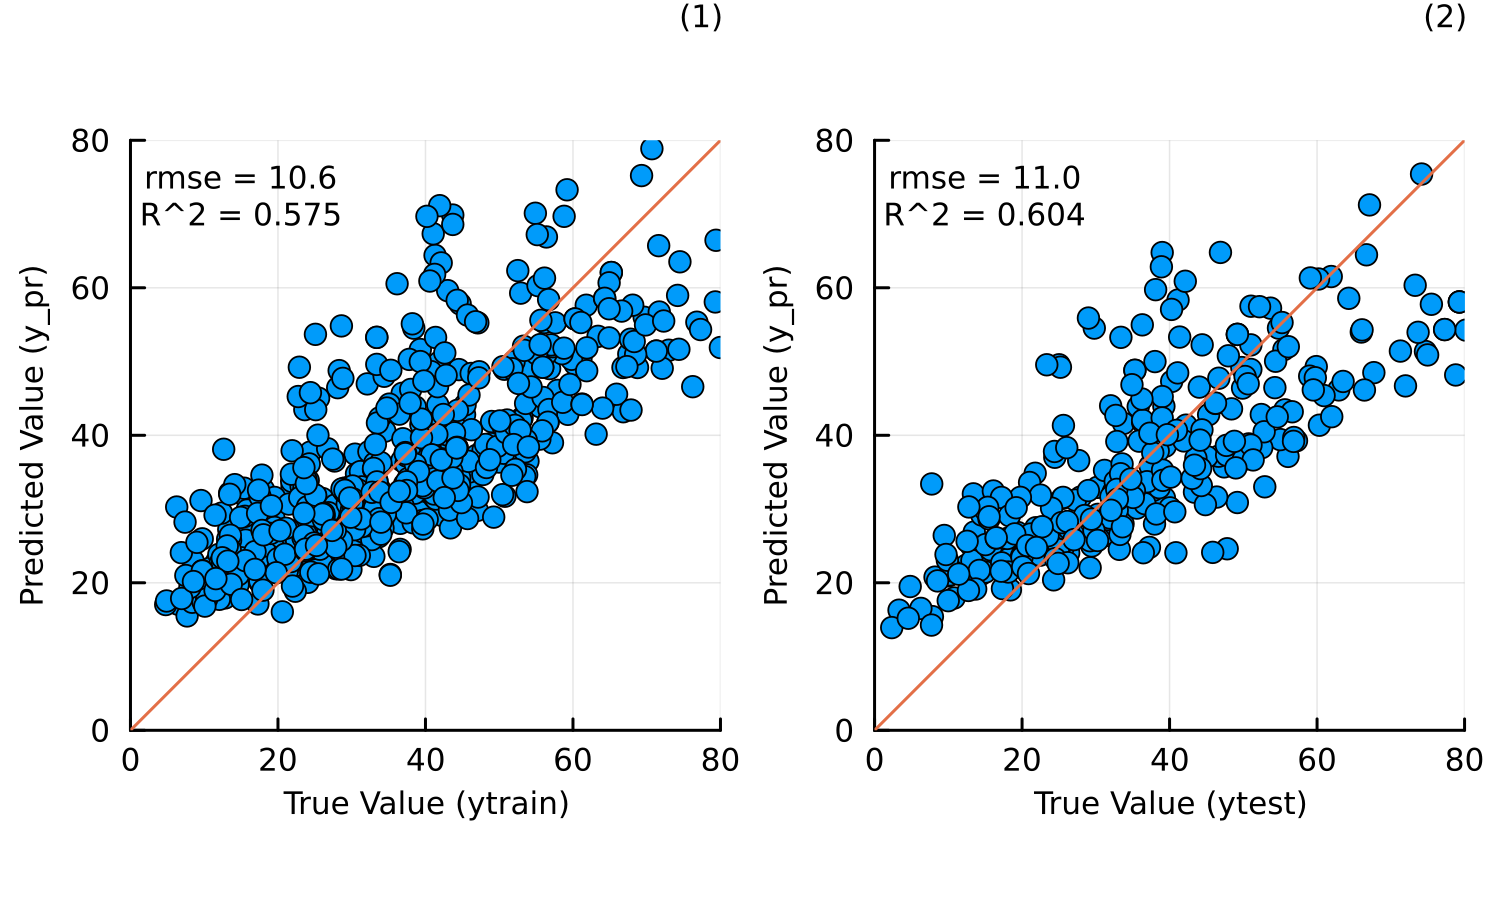

"/Users/pimbodj/Documents/GitHub/cee-492-term-project-fall-2022-team-online/reference/4-Neural Networks/NeuralNetworkNorm.png"

In [209]:
y_pr_trainnorm = twolayer_logistic(xtrainnorm, pnorm)
y_pr_testnorm = twolayer_logistic(xtestnorm, pnorm)

display(plottraintest(ytrain', y_pr_trainnorm', ytest', y_pr_testnorm'))
savefig(joinpath(dirname(@__FILE__), "NeuralNetworkNorm.png")) # uncomment to save figure

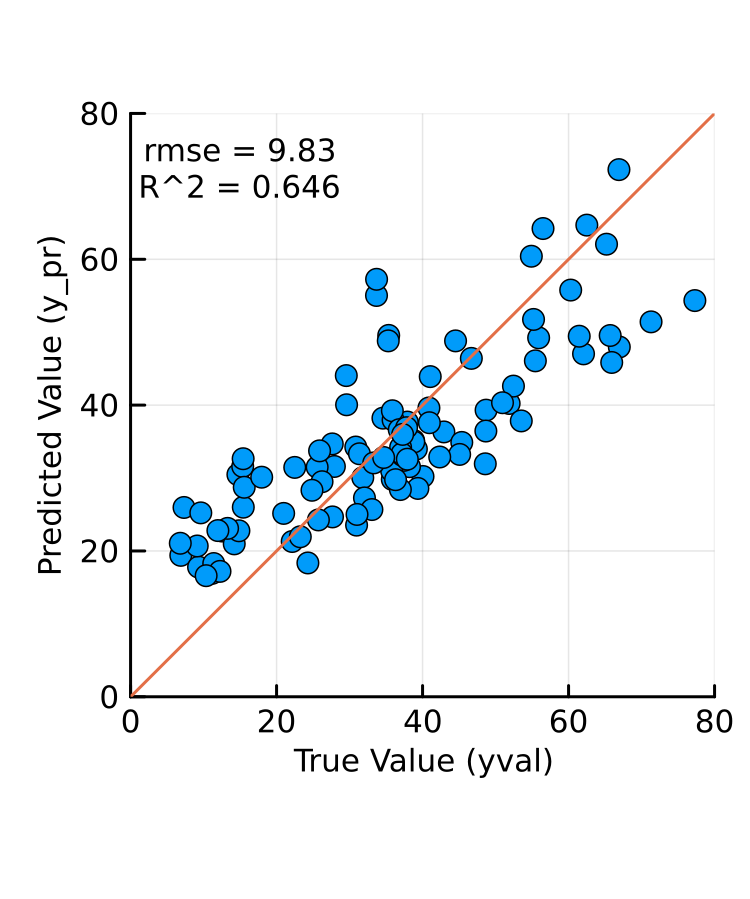

"/Users/pimbodj/Documents/GitHub/cee-492-term-project-fall-2022-team-online/reference/4-Neural Networks/NNValNorm.png"

In [210]:
y_pr_valnorm = twolayer_logistic(xvalnorm, pnorm)

display(plotval(yval', y_pr_valnorm'))
savefig(joinpath(dirname(@__FILE__), "NNValNorm.png"))

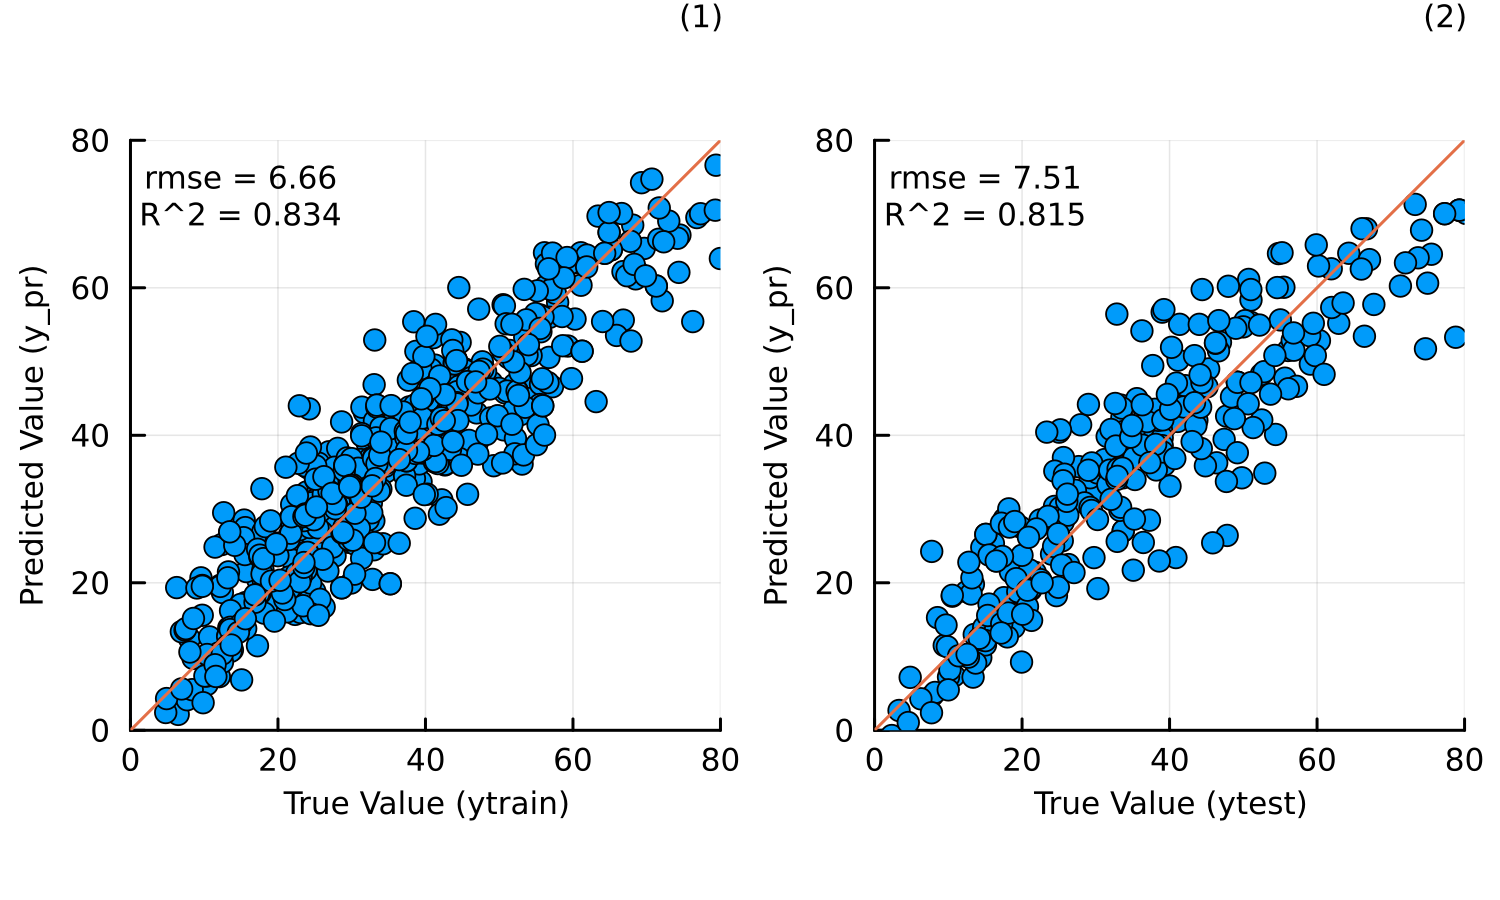

"/Users/pimbodj/Documents/GitHub/cee-492-term-project-fall-2022-team-online/reference/4-Neural Networks/NeuralNetwork.png"

In [211]:
y_pr_train = twolayer_logistic(xtrain, p)
y_pr_test = twolayer_logistic(xtest, p)

display(plottraintest(ytrain', y_pr_train', ytest', y_pr_test'))
savefig(joinpath(dirname(@__FILE__), "NeuralNetwork.png")) # uncomment to save figure

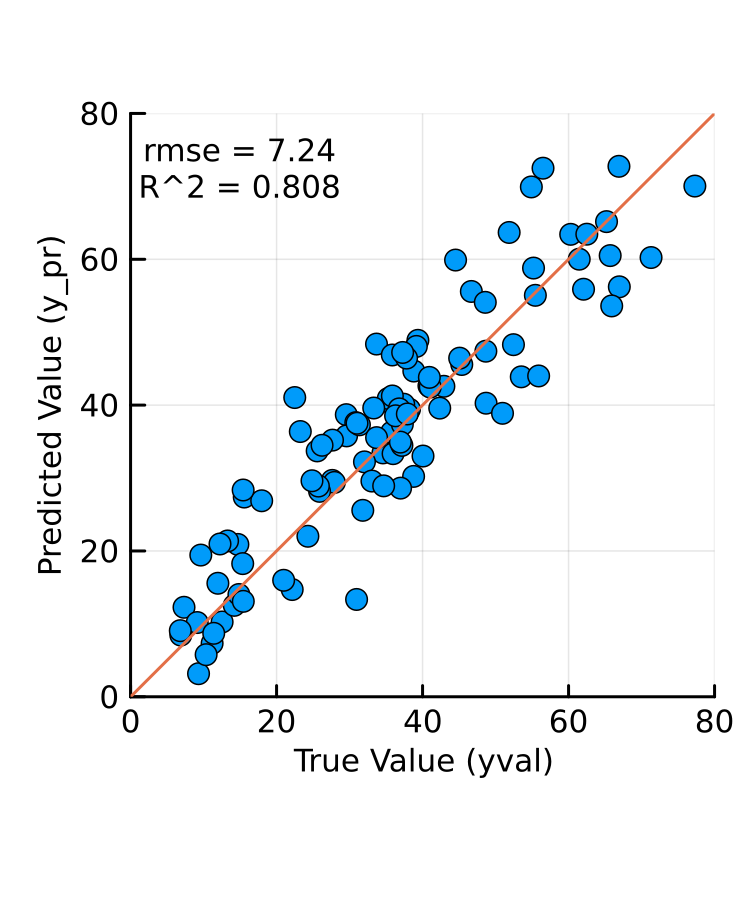

"/Users/pimbodj/Documents/GitHub/cee-492-term-project-fall-2022-team-online/reference/4-Neural Networks/NNVal.png"

In [212]:
y_pr_val = twolayer_logistic(xval, p)

display(plotval(yval', y_pr_val'))
savefig(joinpath(dirname(@__FILE__), "NNVal.png"))